# **Project 3: Team Norman Borlaug**

## **2015-16 File**

#### Group Members:
> Mary  -  marylaska@berkeley.edu <br>
> Jack - jackpollard@berkeley.edu<br>
> Jocelyn - jocelynvelazquez@berkeley.edu <br>
> Vivian - yumeng.zhang0502@berkeley.edu <br>
> Steven -  k1519632@berkeley.edu <br>


## Project Setup

In [1]:
#import packages

In [2]:
!pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets
import cfe.regression as rgsn

# [A] Choice of a dataset and regression set-up

We chose the Uganda dataset because it was one of the most comprehensive in our previous project, offering detailed yearly data. We also identified a relevant nutrition policy in Uganda to analyze, allowing us to assess its impact and suggest policy improvements.

In [4]:
uganda_data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'

In [6]:
import cfe

# Define your InputFiles dictionary.

# --------------------------------------------
# YEAR  (2015-16) and Run Cell
#---------------------------------------------

InputFiles = {
    'Expenditures': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2015-16)'), #CHANGE YEAR HERE 
    'Prices': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
    'HH Characteristics': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
    'FCT': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
    'RDI': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),
}


def get_clean_sheet(key, sheet=None):
    """
    Read a sheet from Google Sheets, clean column names and duplicates.
    """
    df = read_sheets(key, sheet=sheet)
    # Strip whitespace from column names.
    df.columns = [c.strip() for c in df.columns.tolist()]
    # Remove duplicate columns, keeping the first occurrence.
    df = df.loc[:, ~df.columns.duplicated(keep='first')]
    # Drop columns that start with 'Unnamed'
    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)
    # Drop duplicate rows based on the index.
    df = df.loc[~df.index.duplicated(), :]
    # Also drop any completely duplicate rows.
    df = df.drop_duplicates()
    return df


def load_data(InputFiles):
    """
    Load and preprocess the Expenditures, HH Characteristics, Prices, FCT, and RDI data.
    Returns:
      x: Expenditures DataFrame indexed by ['i','t','m'] with columns 'j'
      z: Household characteristics DataFrame indexed by ['i','t','m']
      p, fct, rdi: Other data sets (if needed for later analysis)
    """
    # Get expenditures
    x = get_clean_sheet(InputFiles['Expenditures'][0],
                        sheet=InputFiles['Expenditures'][1])
    if 'm' not in x.columns:
        x['m'] = 1
    x = x.set_index(['i','t','m'])
    x.columns.name = 'j'
    x = x.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    x = x.replace(0, np.nan)
    
    # Get HH Characteristics
    z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                        sheet=InputFiles['HH Characteristics'][1])
    if 'm' not in z.columns:
        z['m'] = 1
    z = z.set_index(['i','t','m'])
    z.columns.name = 'k'
    z = z.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    
    # Get Prices (if needed later)
    p = get_clean_sheet(InputFiles['Prices'][0],
                        sheet=InputFiles['Prices'][1])
    if 'm' not in p.columns:
        p['m'] = 1
    p = p.set_index(['t','m'])
    p.columns.name = 'j'
    p = p.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    p = p.replace(0, np.nan)
    
    # Get FCT
    fct = get_clean_sheet(InputFiles['FCT'][0],
                          sheet=InputFiles['FCT'][1])
    fct = fct.set_index('j')
    fct.columns.name = 'n'
    fct = fct.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    
    # Get RDI
    rdi = get_clean_sheet(InputFiles['RDI'][0],
                          sheet=InputFiles['RDI'][1])
    rdi = rdi.set_index('n')
    rdi.columns.name = 'k'
    
    return x, z, p, fct, rdi


def prepare_expenditures_for_regression(x):
    """
    Convert the Expenditures DataFrame to a 1D Series (y) for regression.
    This function aggregates duplicate (i,t,m,j) combinations using the mean,
    then takes the natural log.
    """
    # Stack the expenditures so that columns (j) become part of the index.
    # Reset index to make all index levels into columns.
    df_long = x.stack().reset_index(name='expenditure')
    # Now, if duplicates exist in (i,t,m,j), aggregate them.
    df_agg = df_long.groupby(['i', 't', 'm', 'j'])['expenditure'].mean().reset_index()
    # Set the multi-index again.
    y = df_agg.set_index(['i', 't', 'm', 'j'])['expenditure']
    # Take the log of expenditures.
    y_log = np.log(y)
    return y_log


def run_regression(x, z):
    """
    Prepare the data and run the regression of log(expenditures) on household characteristics.
    Returns the regression result from cfe.
    """
    # Prepare y (dependent variable)
    y_log = prepare_expenditures_for_regression(x)
    
    # Run the regression.
    result = cfe.Regression(y=y_log, d=z)
    return result


# =============================================================================
# Call of the functions:
# =============================================================================

# Load all data.
x, z, p, fct, rdi = load_data(InputFiles)

# preview of data:
#display(x.head())
#display(z.head())
#display(p.head())
#display(fct.head())
#display(rdi.head())

# Run  regression.
result = run_regression(x, z)

# Display sorted regression coefficients.
beta_sorted = result.get_beta().sort_values(ascending=False)
#print(beta_sorted.head(20))


In [7]:
result.to_pickle('./foo.pickle')

In [8]:
import cfe

result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

In [9]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

n
Energy          66946.814173
Protein          1963.755714
Fiber             969.612090
Folate          14218.173282
Calcium         22539.423713
Carbohydrate     9748.246212
Iron              551.899337
Niacin            522.119072
Riboflavin         50.131218
Thiamin            55.482620
Vitamin A       12777.001664
Vitamin B-12       75.312097
Vitamin B-6        66.609998
Vitamin C        6048.491870
Zinc              310.290879
dtype: float64

# Unit test 1 - reasonable values for households per week

In [45]:
# Use nutrient means instead of full Series
means = nutrients.mean()

energy    = means['Energy']
protein   = means['Protein']
calcium   = means['Calcium']
vitamin_c = means['Vitamin C']
zinc      = means['Zinc']
vitamin_a = means['Vitamin A']

# Simple unit tests for household-level nutrient totals (weekly)
assert 40_000 < energy < 100_000, "Energy out of expected range"
assert 1_000 < protein < 3_000, "Protein out of expected range"
assert 5_000 < calcium < 30_000, "Calcium out of expected range"
assert 5_000 < vitamin_c < 10_000, "Vitamin C unusually high/low"
assert    50 < zinc    <    600, "Zinc intake outside expected range"
assert 5_000 < vitamin_a < 20_000, "Vitamin A value suspect"

print("✅ Nutrient intake values are within expected weekly household ranges.")


✅ Nutrient intake values are within expected weekly household ranges.


In [46]:
yhat = result.get_predicted_log_expenditures()

# [A] Estimate Demand System

### Setting up demand system from project 3

In [11]:

def process_data_per_year(uganda_data, year):
    # --- Food Expenditures ---
    sheet_expend = f"Food Expenditures ({year})"
    x = read_sheets(uganda_data, sheet=sheet_expend)
    x = x.set_index(['i', 't', 'm', 'j']).squeeze()
    
    # --- Food Prices ---
    sheet_prices = f"Food Prices ({year})"
    p = read_sheets(uganda_data, sheet=sheet_prices).set_index(['t', 'm', 'j', 'u'])
    p = p.groupby(['t', 'm', 'j', 'u']).median()
    
    # Directly select prices in kilograms
    p = p.xs('Kg', level='u').squeeze().unstack('j')
    # Align to only the goods you estimated
    p = p[x.index.levels[-1]].T

    # --- Household Characteristics ---
    d = read_sheets(uganda_data, sheet="Household Characteristics")
    d = d[d.t == year]
    d.columns.name = 'k'
    d = d.replace(np.nan, 0)
    d.set_index(['i', 't', 'm'], inplace=True)
    
    # --- Expenditures Processing ---
    x = x.T.groupby(['i', 't', 'm', 'j']).sum()
    x = x.replace(0, np.nan)
    y = np.log(x)
    
    return x, y, d


# --------------------------------------------
# YEAR (2009-10) and Run Cell
#---------------------------------------------
x, y, d = process_data_per_year(uganda_data,"2015-16")

#print("Food Expenditures (x)")
#display(x.head())

#print("Household Characteristics (d)")
#display(d.head())

#print("Log of Expenditures (y)")
#isplay(y.head())

In [12]:
result.predicted_expenditures()

i             t        m        j             
1013000201    2015-16  Central  Beans              4359.723408
                                Beef              11706.701341
                                Beer              18596.857579
                                Bread              4516.517584
                                Cabbages           1219.872365
                                                      ...     
H43010-04-01  2015-16  Western  Sugar              2201.115326
                                Sweet Bananas      2390.323813
                                Sweet Potatoes     6135.326856
                                Tea                 305.945678
                                Tomatoes           1619.229824
Length: 113479, dtype: float64

In [13]:
result = rgsn.Regression(y=y,d=d)

In [14]:
beta = result.get_beta()
#beta.head

In [15]:
gamma = result.get_gamma()
#gamma.head

### Saving Result

In [16]:
result.to_pickle('uganda_estimates.rgsn')

In [17]:
import cfe
result = cfe.regression.read_pickle('uganda_estimates.rgsn')


### **New Code Starts Here**

#### Reference Prices

In [18]:
col_prices = p.mean(axis=0)

pbar = col_prices.groupby(level='j').mean()

# Keep only the goods you have betas for, fill missing with 1
pbar = pbar.reindex(result.beta.index).fillna(1)

def my_prices(p0, j, p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p


#### Budgets

In [19]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities 

In [20]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

#qhat.head(4)

In [21]:
def my_prices(j,p0,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands

#### Demand Functions -  how quantity demanded responds to price changes at different budget percentiles.

In [22]:
%matplotlib inline


Text(0.5, 0, 'Quantities of Maize (flour) Demanded')

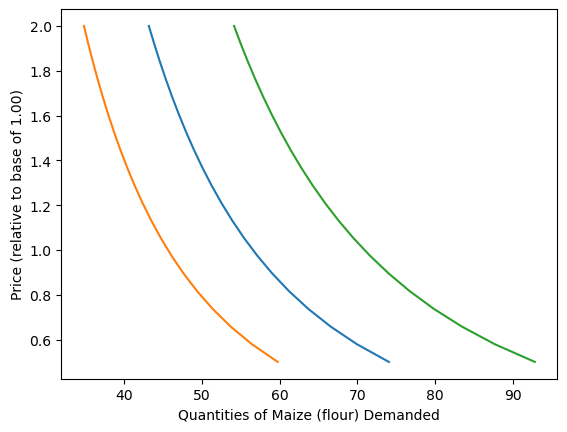

In [23]:
import matplotlib.pyplot as plt

use = 'Maize (flour)'  # CHANGE FOOD TYPE HERE

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand  for household at median budget
plt.plot([result.demands(xref,my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves - how expenditure shares change with income.

/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -3.64E-12.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))


Text(0.5, 1.0, 'Engel Curves')

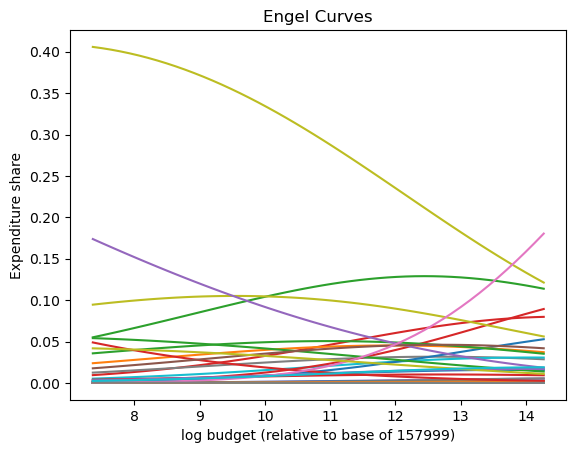

In [24]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

# [A] Construct Nutrient System

#### Mapping to Nutrients

In [25]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Avocado', 'Beans (dry)', 'Beef', 'Bread', 'Cassava (fresh)', 'Chapati',
       'Cooking Oil', 'Dodo', 'Eggplant', 'Eggs', 'Fresh Fish', 'Goat Meat',
       'Ground Nuts (pounded)', 'Ground Nuts (shelled)', 'Mangos', 'Millet',
       'Onions', 'Oranges', 'Pork', 'Pumpkins', 'Sim Sim', 'Sugar',
       'Sweet Bananas', 'Sweet Potatoes (fresh)', 'Tomatoes'],
      dtype='object', name='j')


In [26]:
N = fct0.T@c0

N.head()  #NB: Uganda quantities are for previous 7 days

i,H0010101,H0010201,H0010401,H0020801,H0020901,H0021101,H0021301,H0030101,H0030201,H0030301,...,H4300101,H4300201,H4300301,H4300501,H4300601,H4300701,H4300801,H4300901,H4300902,H4301001
t,2015-16,2015-16,2015-16,2015-16,2015-16,2015-16,2015-16,2015-16,2015-16,2015-16,...,2015-16,2015-16,2015-16,2015-16,2015-16,2015-16,2015-16,2015-16,2015-16,2015-16
m,Central,Central,Central,Central,Central,Central,Central,Central,Central,Central,...,Western,Western,Western,Western,Western,Western,Western,Western,Western,Western
n,,,,,,,,,,,,,,,,,,,,,
Energy,7.914490e+07,4.337865e+07,3.786241e+07,8.535094e+07,7.417382e+07,8.713536e+07,6.994858e+07,5.734327e+07,3.136301e+07,1.350771e+08,...,6.653556e+07,4.536243e+07,1.213460e+08,1.154016e+08,1.048118e+08,7.120257e+07,6.795095e+07,1.212093e+08,5.365886e+07,8.251607e+07
Protein,6.858336e+06,3.135833e+06,2.842477e+06,6.619766e+06,6.048449e+06,7.306293e+06,5.303138e+06,4.596481e+06,2.489760e+06,1.043989e+07,...,5.420075e+06,3.598549e+06,1.082556e+07,8.791392e+06,7.540383e+06,5.809058e+06,5.034961e+06,9.059793e+06,4.331641e+06,6.269396e+06
Fiber,1.112251e+06,7.097121e+05,5.904751e+05,1.333053e+06,1.092037e+06,1.286157e+06,1.130424e+06,8.485630e+05,4.706947e+05,2.158074e+06,...,9.695066e+05,6.668768e+05,1.651245e+06,1.784605e+06,1.708483e+06,1.052272e+06,1.083829e+06,1.966064e+06,7.894240e+05,1.284416e+06
Folate,1.781367e+07,1.111104e+07,8.851910e+06,2.070842e+07,1.724469e+07,1.822248e+07,1.597636e+07,1.287856e+07,7.177264e+06,3.250106e+07,...,1.610303e+07,1.090759e+07,2.567352e+07,2.837293e+07,2.737804e+07,1.702100e+07,1.738078e+07,2.962685e+07,1.299610e+07,2.003402e+07
Calcium,1.292593e+07,7.694200e+06,6.702089e+06,1.469176e+07,1.241184e+07,1.473749e+07,1.233006e+07,9.673684e+06,5.343552e+06,2.355070e+07,...,1.116222e+07,7.752614e+06,1.999573e+07,1.980192e+07,1.860771e+07,1.209970e+07,1.205547e+07,2.172195e+07,9.078690e+06,1.422884e+07


In [27]:
def nutrient_demand(x,p):
    c = result.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

Text(0, 0.5, 'log nutrient')

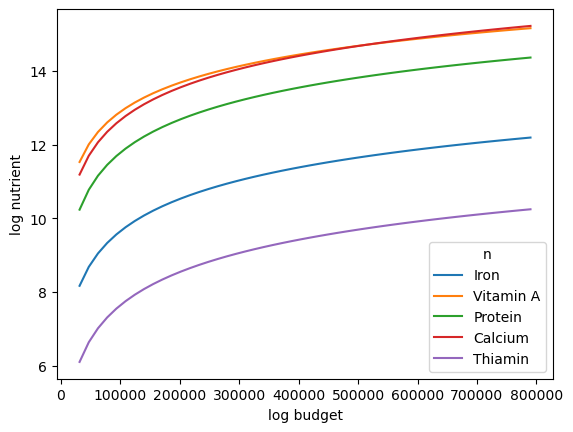

In [28]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

#--------------------------
#ADD OR CHANGE NUTRIENTS HERE
#----------------------------
UseNutrients = ['Iron', 'Vitamin A', 'Protein', 'Calcium', 'Thiamin']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Text(0, 0.5, 'log nutrient')

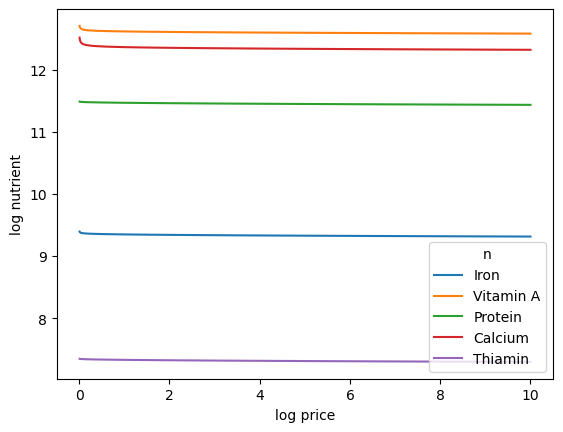

In [29]:
#--------------------------------------
#Pick a food high ion Vitamin A and Iron
#----------------------------------------

USE_GOOD = 'Dodo'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(USE_GOOD,pbar[USE_GOOD]*s)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

#### Nutritional Needs of Households

In [30]:
# In first round, averaged over households and villages
columns_to_average = [col for col in d.columns if col.startswith('Females') or col.startswith('Males')]

dbar = d[columns_to_average].mean()

In [31]:
rdi_renamed = rdi.copy()
rdi_renamed.columns = rdi_renamed.columns.to_series() \
    .str.replace('^F ', 'Females ', regex=True) \
    .str.replace('^M ', 'Males ', regex=True) \
    .str.replace('51\\+', '51-99', regex=True)

# Reorder columns to match dbar index
rdi_aligned = rdi_renamed[dbar.index]

# Matrix multiply
hh_rdi = rdi_aligned @ dbar   # example: for 7 days
hh_rdi

n
Energy           8506.807867
Protein           190.572466
Fiber             119.095310
Folate           1591.331316
Calcium          5150.468986
Carbohydrate      621.875946
Iron               51.905295
Magnesium        1370.726172
Niacin             60.675340
Phosphorus       3888.726172
Potassium       21005.869894
Riboflavin          4.751831
Thiamin             4.611346
Vitamin A        3174.251135
Vitamin B-12        9.547988
Vitamin B-6         5.264266
Vitamin C         287.918306
Vitamin E          59.241452
Vitamin K         379.995461
Zinc               38.626929
dtype: float64

# Unit Test 2 for reasonable values

In [41]:
# Sanity checks: reasonable household RDI values (7 days)
assert 1000 < hh_rdi['Energy'] < 15000, "Energy RDI out of bounds"
assert 100 < hh_rdi['Protein'] < 500, "Protein RDI seems too high or low"
assert 4000 < hh_rdi['Calcium'] < 8000, "Calcium RDI out of bounds"
assert 10 < hh_rdi['Iron'] < 200, "Iron RDI seems unrealistic"
assert 1000 < hh_rdi['Potassium'] < 30000, "Potassium RDI suspiciously high/low"
assert 10 < hh_rdi['Zinc'] < 100, "Zinc RDI not plausible"

print("✅ Household RDI values fall within expected ranges.")


✅ Household RDI values fall within expected ranges.


In [32]:
rdi_aligned.head()


k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99
n,,,,,,,,,,,,,,
Energy,1000.0,1200.0,1600.0,1800.0,2000.0,1800.0,1600.0,1000.0,1400.0,1800.0,2200.0,2400.0,2200.0,2000.0
Protein,13.0,19.0,34.0,46.0,46.0,46.0,46.0,13.0,19.0,34.0,52.0,56.0,56.0,56.0
Fiber,14.0,16.8,22.4,25.2,28.0,25.2,22.4,14.0,19.6,25.2,30.8,33.6,30.8,28.0
Folate,150.0,200.0,300.0,400.0,400.0,400.0,400.0,150.0,200.0,300.0,400.0,400.0,400.0,400.0
Calcium,700.0,1000.0,1300.0,1300.0,1000.0,1000.0,1200.0,700.0,1000.0,1300.0,1300.0,1000.0,1000.0,1000.0


In [33]:
dbar

k
Females 00-03    0.191225
Females 04-08    0.396369
Females 09-13    0.367020
Females 14-18    0.323449
Females 19-30    0.483812
Females 31-50    0.428442
Females 51-99    0.253253
Males 00-03      0.180635
Males 04-08      0.377307
Males 09-13      0.377307
Males 14-18      0.357943
Males 19-30      0.462935
Males 31-50      0.360061
Males 51-99      0.223903
dtype: float64

### Nutritional Adequacy of Food Demands


In [34]:
def nutrient_adequacy_ratio(x, p, d, rdi = rdi_aligned, days=7):
    # 1) copy & rename RDI columns so they line up with d.index
    rdi_clean = rdi.copy()
    rdi_clean.columns = (
        rdi_clean.columns
        .to_series()
        .str.replace('F ', 'Females ', regex=False)
        .str.replace('M ', 'Males ',   regex=False)
    )
    rdi_clean.columns = rdi_clean.columns.str.replace('51\\+', '51–99', regex=True)

    # 2) replace any blank entries with zero
    rdi_clean = rdi_clean.replace('', 0)

    # 3) re-order (and fill) so that columns == d.index
    #    any missing columns become zeros
    rdi_aligned = rdi_clean.reindex(columns=d.index, fill_value=0)

    # 4) compute household RDI and divide demand by it
    hh_rdi = (rdi_aligned @ d) * days
    return nutrient_demand(x, p) / hh_rdi


/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -3.64E-12.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.82E-12.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.82E-12.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps toleranc

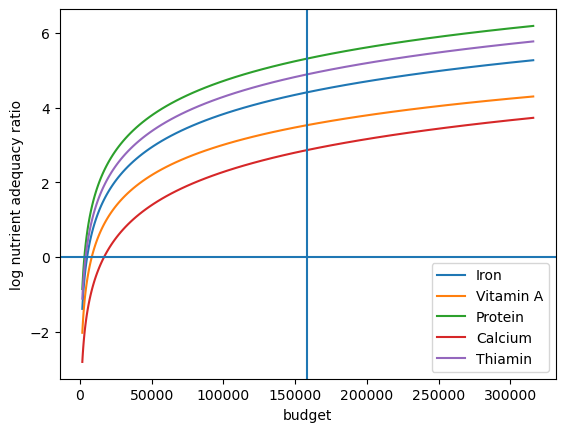

In [35]:
X = np.geomspace(.01 * xref, 2 * xref, 100)

pd.DataFrame({
    x: np.log(nutrient_adequacy_ratio(x, pbar, dbar, rdi))[UseNutrients] for x in X
}).T.plot()

plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(xref)


Text(0.5, 0, 'log nutrient adequacy ratio')

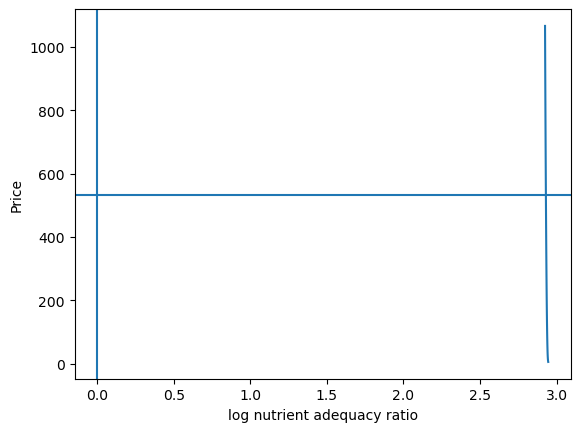

In [36]:
scale = np.geomspace(.01,2,50)

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(USE_GOOD,pbar[USE_GOOD]*s),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Thiamin'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')

# [A] Nutritional challeneges & Policy Goal

### use example costs notebook Arpil 22nd

In [37]:
use_nutrients = nutrients.columns.intersection(hh_rdi.index.to_numpy())

nutrient_ratio = (nutrients[use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()

nutrient_ratio

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
1013000201,2015-16,Central,1.067386,1.421637,0.813627,1.078671,0.612421,1.680246,1.301375,1.014492,1.509372,1.562268,0.559947,1.478311,1.639142,2.110087,1.073648
1013000202,2015-16,Central,0.539850,0.721681,0.426604,0.525271,0.306611,0.867532,0.668098,0.537157,0.711057,0.840413,0.257833,0.674811,0.810185,1.011172,0.561061
1013000204,2015-16,Central,0.401065,0.524718,0.331246,0.396672,0.251592,0.652035,0.508908,0.404639,0.504840,0.634803,0.174860,0.500881,0.606770,0.851583,0.437701
1013000210,2015-16,Central,0.612929,0.823800,0.455548,0.610549,0.372048,0.915099,0.762884,0.589428,0.844010,0.940367,0.306945,0.847713,0.910365,1.178099,0.640693
1021000108,2015-16,Central,1.263183,1.725311,1.002195,1.333446,0.743817,2.036319,1.606925,1.220614,1.902540,1.842581,0.726656,1.877049,2.092114,2.682843,1.306122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H43007-04-01,2015-16,Western,0.902579,1.211664,0.862967,1.033720,0.413003,1.750732,1.044384,0.997924,1.244755,1.354526,0.444820,1.033094,1.438828,1.930395,0.859609
H43008-04-01,2015-16,Western,0.857071,1.134790,0.863078,0.992312,0.379138,1.712553,0.997131,0.968951,1.140420,1.300789,0.397814,0.892811,1.344024,1.807476,0.819259
H43009-04-01,2015-16,Western,0.926291,1.292096,1.018429,1.193154,0.459541,1.928152,1.209436,1.108941,1.415373,1.409963,0.529492,1.177690,1.667321,2.453949,0.976406


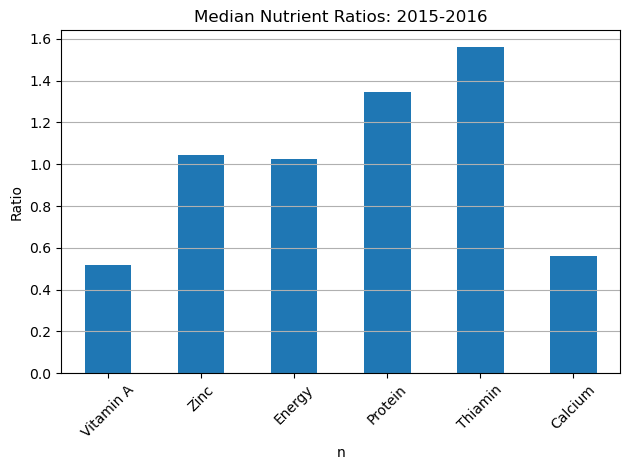

In [38]:
import matplotlib.pyplot as plt

selected_nutrients = ['Vitamin A','Zinc', 'Energy', 'Protein', 'Thiamin', 'Calcium']
nutrient_means = nutrient_ratio[nutrient_ratio[selected_nutrients] != 0][selected_nutrients].median()
nutrient_means.plot(kind='bar')
plt.title('Median Nutrient Ratios: 2015-2016')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
ax.axhline(1, color='red', linestyle=':')  # ← dotted red line at y=1
plt.show()

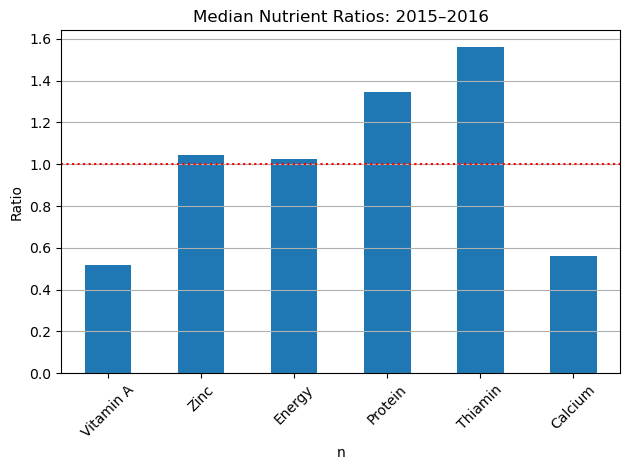

In [39]:
import matplotlib.pyplot as plt

selected_nutrients = ['Vitamin A', 'Zinc', 'Energy', 'Protein', 'Thiamin', 'Calcium']
nutrient_means = (
    nutrient_ratio
    [nutrient_ratio[selected_nutrients] != 0]
    [selected_nutrients]
    .median()
)
nutrient_means.plot(kind='bar')
plt.title('Median Nutrient Ratios: 2015–2016')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.axhline(1, color='red', linestyle=':')

plt.show()


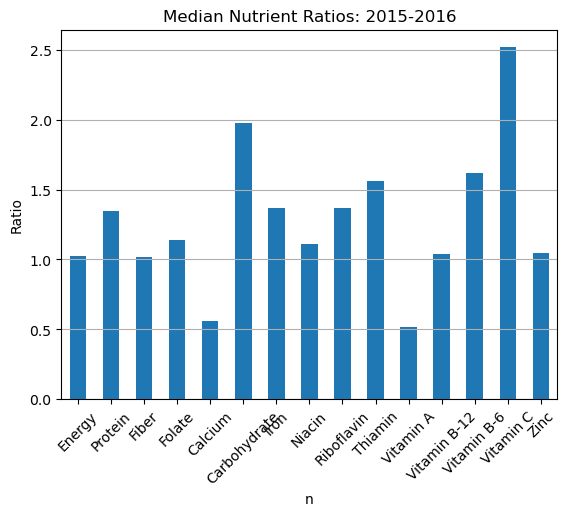

In [40]:
nutrient_means = nutrient_ratio[nutrient_ratio[use_nutrients] != 0][use_nutrients].median()
nutrient_means.plot(kind='bar')
plt.title('Median Nutrient Ratios: 2015-2016')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout
plt.show()

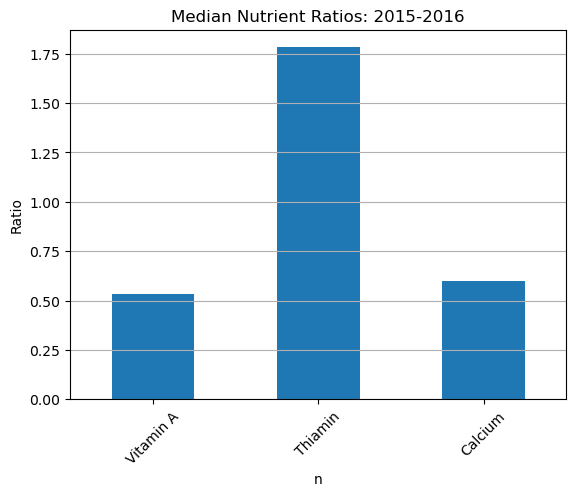

In [41]:
central_NR = (nutrients[nutrients.index.get_level_values("m") == "Central"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()
east_NR = (nutrients[nutrients.index.get_level_values("m") == "Eastern"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()
west_NR = (nutrients[nutrients.index.get_level_values("m") == "Western"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()
north_NR = (nutrients[nutrients.index.get_level_values("m") == "Northern"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()


selected_nutrients = ['Vitamin A','Thiamin', 'Calcium']
nutrient_means_c = central_NR[central_NR[selected_nutrients] != 0][selected_nutrients].median()
nutrient_means_e = east_NR[east_NR[selected_nutrients] != 0][selected_nutrients].median()
nutrient_means_w = west_NR[west_NR[selected_nutrients] != 0][selected_nutrients].median()
nutrient_means_n = west_NR[north_NR[selected_nutrients] != 0][selected_nutrients].median()

nutrient_means_c.plot(kind='bar')
nutrient_means_e.plot(kind='bar')
nutrient_means_w.plot(kind='bar')

plt.title('Median Nutrient Ratios: 2015-2016')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout
plt.show()

# [B] Policy Options

# [C] Policy Costs

In [42]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
x0 = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Marshallian vs. Hicksian Demand Curves


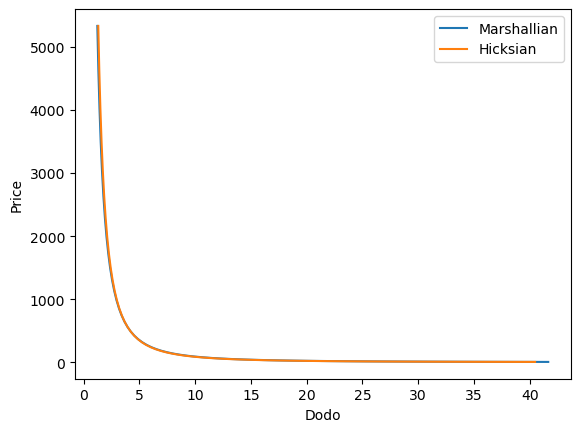

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

my_j = 'Dodo'  # Interesting Ugandan staple

P = np.geomspace(.01,10,50)*pbar[my_j]

# Utility of median household, given prices
U0 = result.indirect_utility(x0,pbar)

plt.plot([result.demands(x0,my_prices(my_j,p0))[my_j] for p0 in P],P)
plt.plot([result.demands(U0,my_prices(my_j,p0),type="Hicksian")[my_j] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_j)
plt.legend(("Marshallian","Hicksian"))

#### Welfare Measures

In [44]:
def compensating_variation(U0,p0,p1):
    x0 = result.expenditure(U0,p0)
    x1 = result.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = result.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian')

#### Price Changes, Revenue, and Compensating Variation



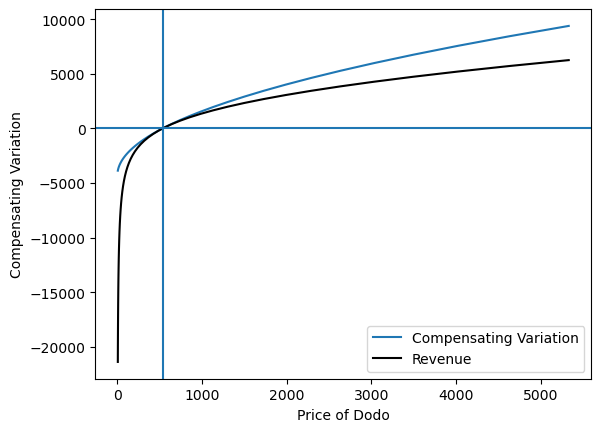

In [45]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,pbar,my_prices(my_j,p0)) for p0 in P])
ax1.set_xlabel(f"Price of {my_j}")
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,pbar,my_prices(my_j,p0),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(pbar.loc[my_j])

#### Deadweight Loss


Text(0, 0.5, 'Deadweight Loss')

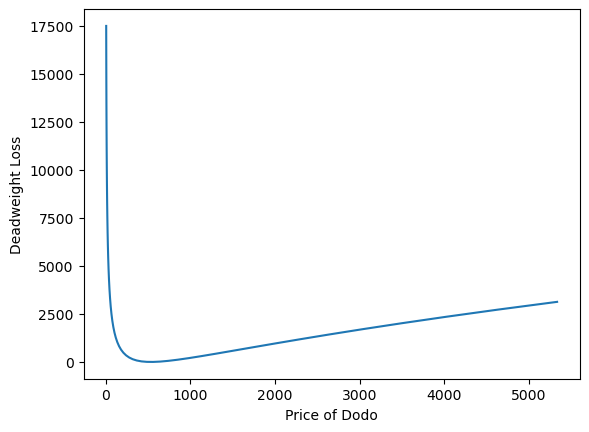

In [46]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,pbar,my_prices(my_j,p0)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_j)
ax1.set_ylabel("Deadweight Loss")